# Desarrollo

A continuación, se presenta el avance que se tiene en la creación del prototipo para la aplicación de análisis de sentimiento a las conferencias de prensa, esta sección ha sido desarrollada por medio de la tecnología “Jupyter Notebook” que permite integrar texto y código en un mismo documento. El código está identificado con un tipo diferente de letra y se han mantenido los comentarios, identificados en color azul y por iniciar con el signo “#”. 

Se hace uso de una librería llamada Dynaconf para guardar los datos de configuración en un archivo “.env” separado. Esto facilita que, si alguien más desea ejecutar el código en una computadora diferente, únicamente sea necesario modificar el contenido de ese archivo y no todo el código.

Iniciamos por abrir el archivo para leer su contenido.


In [1]:
from dynaconf import Dynaconf

# Obtener archivo de texto a utilizar como fuente
settings = Dynaconf(load_dotenv=True, envvar_prefix="PFM")

abrir_archivo = settings.FILE

with open(abrir_archivo, 'r', encoding="UTF-8") as file:
    text = file.read()

Una vez que tenemos el archivo disponible se realizan otras tareas de limpieza, las cuales están indicadas en los comentarios del código.

In [2]:
import string
from nltk import word_tokenize
from nltk.corpus import stopwords

# Separar palabras
tokens = word_tokenize(text)

# Transformar a minúsculas
tokens = [w.lower() for w in tokens]

# Quitar puntuación
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in tokens]

# Quitar otros caracteres no alfanuméricos
words = [word for word in stripped if word.isalpha()]

# Quitar palabras comunes (stop words)
stop_words = stopwords.words('spanish')

# Agregar palabras que se pueden considerar superfluas y que no están en el paquete de stopwords
personal_words = ['si','mas', 'buenos', 'buenas', 'días', 'gracias', 'señor', 'presidente', 'así']

stop_words = stop_words + personal_words

words = [w for w in words if not w in stop_words]


Al finalizar las operaciones de limpieza, una de las cosas que podemos hacer es determinar la distribución de frecuencia de las palabras en el texto y graficar las palabras más comunes.

In [3]:
from nltk.probability import FreqDist
import pandas as pd
# Obtener la frecuencia de las palabras
freq_dist = FreqDist(words)

df = pd.DataFrame(list(freq_dist.items()), columns = ["Word","Frequency"])

Antes de realizar la gráfica, se procede a mostrar la lista de palabras junto con el número de veces que aparece.

In [4]:
# Mostrar las 30 más usadas con su número de apariciones
df.sort_values('Frequency', ascending=False).head(30)

,Word,Frequency
958,entonces,14798
11,vamos,14227
139,va,14191
78,méxico,12792
194,mil,12488
425,gobierno,9380
748,aquí,9213
131,ahora,7475
67,caso,7434
68,ver,7383


Y después se realiza la gráfica.

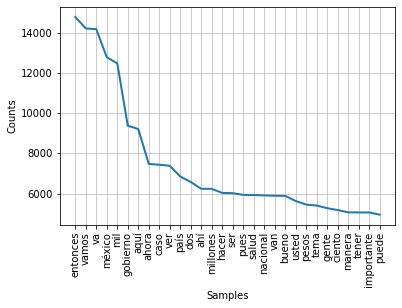

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [5]:
# Graficar las 30 más utilizadas
freq_dist.plot(30, cumulative=False)

Otra actividad que podemos hacer es localizar los “ngrams” más comunes. Un “ngram” es un grupo de 2 o más palabras y nltk ofrece funciones para localizar los grupos de 2, 3 y 4 palabras.

Grupos de 2 palabras o “bigrams”:

In [6]:
import nltk.collocations as nc

bigram_finder = nc.BigramCollocationFinder.from_words(words)
bigram_finder.ngram_fd.most_common(5)
bigram_finder.ngram_fd.tabulate(5)

    ('mil', 'millones')   ('millones', 'pesos')    ('ciudad', 'méxico') ('guardia', 'nacional')   ('pesos', 'centavos') 
                   2594                    2278                    1801                    1657                    1574 


Grupos de 3 palabras o “trigrams”

In [7]:
trigram_finder = nc.TrigramCollocationFinder.from_words(words)
trigram_finder.ngram_fd.most_common(5)
trigram_finder.ngram_fd.tabulate(5)

           ('mil', 'millones', 'pesos') ('comisión', 'federal', 'electricidad')          ('pesos', 'centavos', 'litro')    ('fiscalía', 'general', 'república')          ('mil', 'millones', 'dólares') 
                                   1481                                     665                                     518                                     500                                     342 


Grupos de 4 palabras o “quadgrams”

In [8]:
quadgram_finder = nc.QuadgramCollocationFinder.from_words(words)
quadgram_finder.ngram_fd.most_common(5)
quadgram_finder.ngram_fd.tabulate(5)

     ('andrés', 'manuel', 'lópez', 'obrador')      ('pesos', 'centavos', 'litro', 'margen') ('instituto', 'mexicano', 'seguro', 'social')           ('dos', 'mil', 'millones', 'pesos')    ('precio', 'público', 'pesos', 'centavos') 
                                          242                                           236                                           145                                           127                                           116 


Lo anterior, aunque nos da información sobre el texto, no es precisamente análisis de sentimiento, que es el objetivo planteado. Para comenzar con ello se utilizará una librería de Python con un modelo de análisis de sentimiento previamente entrenado.

In [9]:
from sentiment_analysis_spanish import sentiment_analysis
from nltk import sent_tokenize

# Generamos una variable para el modelo de análisis de sentimiento
sentiment = sentiment_analysis.SentimentAnalysisSpanish()

# Separamos el texto en frases
sentencias = sent_tokenize(text)

# Variable para almacenar el análisis de sentimiento por frase
prob_sentimiento = []

for s in sentencias:
    prob_sentimiento.append([sentiment.sentiment(s), s])

# Convertir a dataframe y ordenar análisis de sentimiento de positivo a negativo
df = pd.DataFrame(prob_sentimiento, columns=['sentimiento', 'frase']).sort_values(by='sentimiento', ascending=False)

Una vez que hemos guardado la información previamente procesada, se puede mostrar en formato tabular. En este caso la columna “Sentimiento” contiene valore numéricos entre 0 y 1; los que más se acercan a uno corresponden con sentimiento positivo y los que se acercan más a cero con sentimiento negativo.

Primero se muestran los 15 registros con los valores más altos y podemos observar que todos ellos tienen el valor 1, es decir que su sentimiento se analiza como completamente positivo.


In [17]:
print(df.head(n=15).to_string(index=False))

 sentimiento                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     frase
         1.0                                                                     

A continuación, se muestran los últimos 15 registros, que corresponden a los que tienen valores más cercanos a 0 o un sentimiento muy negativo, en este caso el sentimiento incluso esta expresado en notación exponencial debido a que son valores muy pequeños. 

También es importante señalar que, debido a la función utilizada y a diferencia de los 15 primeros registros, el último registro es el que tiene la calificación más baja.


In [18]:
print(df.tail(n=15).to_string(index=False))

 sentimiento                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            